In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import copy
import os
from pathlib import Path

# Setup Device (GPU is recommended)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Define Path to your dataset
# Ensure this matches the OUTPUT_DIR from your previous script
DATA_DIR = Path("dataset/final_split") 
MODEL_SAVE_PATH = "circuit_classifier.pth"

🚀 Using device: cuda:0


In [2]:
# Cell 2: Data Preprocessing and Loading

# Point to the actual dataset location relative to this notebook
DATA_DIR = Path("dataset/training_data") 

BATCH_SIZE = 32

# Define transforms (ImageFolder will auto-discover circuit and non_circuit classes)
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load entire dataset - ImageFolder will auto-discover circuit/ and non_circuit/ as classes
full_dataset = datasets.ImageFolder(str(DATA_DIR), transform=data_transform)

# Split into train and val
from torch.utils.data import random_split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

print(f"✅ Data Loaded Successfully:")
print(f"   Total images: {len(full_dataset)}")
print(f"   Train images: {dataset_sizes['train']}")
print(f"   Val images: {dataset_sizes['val']}")
print(f"   Classes: {class_names}")

✅ Data Loaded Successfully:
   Total images: 4381
   Train images: 3504
   Val images: 877
   Classes: ['circuit', 'non_circuit']


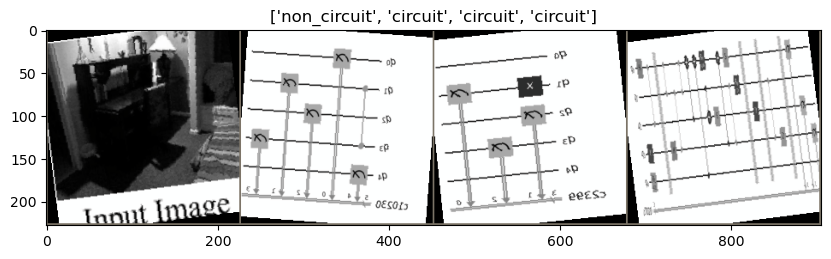

In [3]:
# Cell 3: Visualize a batch of training data
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])

In [4]:
# Cell 4: Initialize Model - ConvNeXt Tiny
import torch.optim as optim

# Load pre-trained ConvNeXt Tiny
# ConvNeXt uses large 7x7 kernels for better long-range context
# Perfect for quantum circuits where control/target bits can be far apart
model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)

# Modify the final classifier layer
# ConvNeXt uses a different structure: classifier[2] is the final Linear layer
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, 2)

# Move model to GPU
model = model.to(device)

# Define Loss Function and Optimizer
# Using AdamW (recommended for ConvNeXt) with lower learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Cosine annealing scheduler (works better with ConvNeXt)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print("✅ ConvNeXt Tiny initialized and moved to GPU.")
print(f"   Large 7x7 kernels for better quantum circuit context!")
print(f"   Classifier: {num_ftrs} -> 2 classes")

✅ ConvNeXt Tiny initialized and moved to GPU.
   Large 7x7 kernels for better quantum circuit context!
   Classifier: 768 -> 2 classes


In [5]:
# Cell 5: Define Training Loop
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Track history for plotting
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if it's the best one so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [6]:
# Cell 6: Run Training
# Train for 10 epochs (usually enough for this task)
trained_model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0565 Acc: 0.9840


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0200 Acc: 0.9932

Epoch 2/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0264 Acc: 0.9920


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0142 Acc: 0.9943

Epoch 3/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0144 Acc: 0.9946


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0228 Acc: 0.9909

Epoch 4/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0098 Acc: 0.9963


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0217 Acc: 0.9920

Epoch 5/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0081 Acc: 0.9960


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0540 Acc: 0.9863

Epoch 6/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0085 Acc: 0.9960


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0187 Acc: 0.9954

Epoch 7/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0056 Acc: 0.9974


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0108 Acc: 0.9954

Epoch 8/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0050 Acc: 0.9969


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0147 Acc: 0.9954

Epoch 9/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0046 Acc: 0.9974


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0131 Acc: 0.9954

Epoch 10/10
----------


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0043 Acc: 0.9974


/home/9826/.local/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


val Loss: 0.0129 Acc: 0.9943

Training complete in 6m 23s
Best val Acc: 0.995439


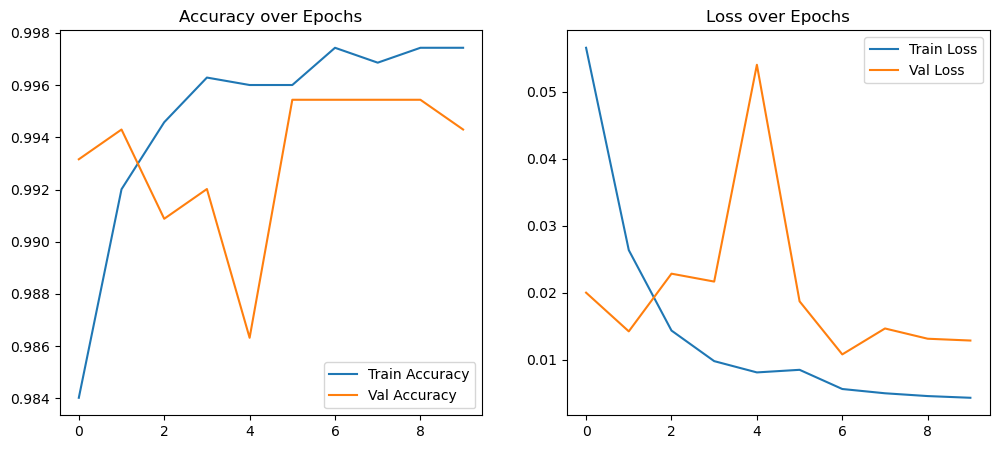

In [7]:
# Cell 7: Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

In [8]:
# Cell 8: Save Model
MODEL_SAVE_PATH = "circuit_classifier.pth"
torch.save(trained_model.state_dict(), MODEL_SAVE_PATH)
print(f"💾 Model saved to {MODEL_SAVE_PATH}")
print("You can now download this file and move it to your project 'src/' folder.")

💾 Model saved to circuit_classifier.pth
You can now download this file and move it to your project 'src/' folder.
